In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
import sounddevice as sd

Usamos la ecuacion de onda con todos los factores, es decir los dos de siempre y agregando amortiguacion y stiffnes

$$ \frac{\partial ^{2}y}{\partial x^{2}} +  \frac{1}{c^{2}} \frac{\partial ^{2}y}{\partial t^{2}} - \gamma \frac{\partial y}{\partial t} - l^{2} \frac{\partial ^{4}y}{\partial x^{4}} = 0 $$ 

Creamos la variables que vamos a necesitar.

In [1]:
Nx = 101  #Longitud en x
Nt = 500000
L =0.7
dx = L/(Nx-1)
f = 220
c = 2*L*f
dt = 5e-6
l=5e-5
gamma=5e-5

In [2]:
c*dt/dx

0.22000000000000003

Ahora creamos las condiciones iniciales. En este caso vamos a simular una cuerda, por eso creamos el desplazamiento vertical de la cuerda y lo almacenamos en un vector.

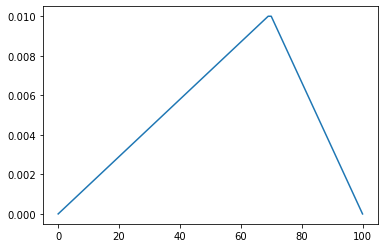

In [3]:
ya = np.linspace(0, 0.01, 70)
yb = np.linspace(0.01, 0, 31)

y0 = np.concatenate([ya, yb])

plt.plot(y0)

Creamos el array donde se va a iterar la solucion y asignamos los dos primeros indices en t el y0 que representa el tocar las cuerda.

In [4]:
sol = np.zeros((Nt, Nx))
sol[0] = y0
sol[1] = y0

Aplicamos la ecuacion de onda disretizada

In [5]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
def compute_d(d, times, length, dt, dx, l, gamma):
    for t in range(1, times-1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

In [6]:
sol = compute_d(sol, Nt, Nx, dt, dx, l, gamma)

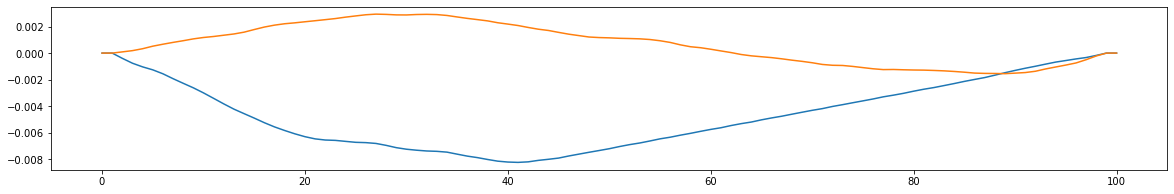

In [7]:
plt.figure(figsize=(20,3))
plt.plot(sol[500])
plt.plot(sol[10000])

Una animacion del proceso. Donde 1 fps = 1/dt. Entonces 1/dx es aporx 200000 frames por segundo. Entonces si skipeo y tomo los frames cada 5 dts voy a tener 40000 fps, que si renderizo el gif a 40 fps me termina quedando una simlucacion con un tiempo 1000 veces mas lento que la realidad.

In [8]:
len(sol[::5,:])

100000

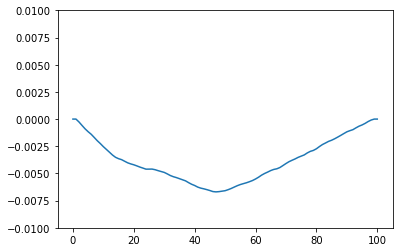

In [9]:
def animate(i):
    ax.clear()
    ax.plot(sol[i*10])
    ax.set_ylim(-0.01, 0.01)
    
fig, ax = plt.subplots(1,1)
ax.set_ylim(-0.01, 0.01)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=20)
ani.save('string.gif',writer='pillow',fps=40)

Formula para encontrar los armonicos predominantes de esta cuerda:

$$ \int_{0}^{L} y(x,t) * sin(\frac{n\pi x}{L}) dx $$

In [10]:
def get_integral_fast(n):
    sin_arr = np.sin(n*np.pi*np.linspace(0,1,101))
    return np.multiply(sol, sin_arr).sum(axis=1)

In [11]:
hms = [get_integral_fast(n) for n in range(10)]

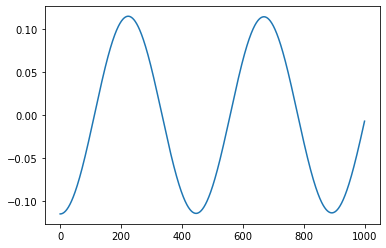

In [12]:
plt.plot(hms[2][0:1000])

In [13]:
all_harmonics=True
if all_harmonics:
    tot = sol.sum(axis=1)[::10] # all harmonics
else:
    tot = sum(hms)[::10] # only first 10 harmonics
tot = tot.astype(np.float32)

In [14]:
audio = tot * 0.2

sd.play(audio,samplerate=44100)

In [15]:
len(audio)

50000

In [16]:
Nt * dt

2.5

In [20]:
fs = 1/dt

In [22]:
1/96000

1.0416666666666666e-05